## Interpolação Espacial

Neste notebook, será realizada a interpolação de variáveis coletadas pelo avião G-1 do projeto GOAmazon 2014/15

In [1]:
# Importação das bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import math
from statistics import mean 

In [2]:
def read_files(estacao):
    """
    Recebe a estação e lê os arquivos referentes à ela
    """
    if estacao == 'seca':
        g1_d17 = pd.read_excel("G1_dryseason_17.xlsx")
        g1_d18 = pd.read_excel("G1_dryseason_18.xlsx")
        g1_d19 = pd.read_excel("G1_dryseason_19.xlsx")
        g1_d20 = pd.read_excel("G1_dryseason_20.xlsx")
        g1_d21 = pd.read_excel("G1_dryseason_21.xlsx")
        g1_d22 = pd.read_excel("G1_dryseason_22.xlsx")
        g1_d23 = pd.read_excel("G1_dryseason_23.xlsx")
        g1_d24 = pd.read_excel("G1_dryseason_24.xlsx")
        g1_d25 = pd.read_excel("G1_dryseason_25.xlsx")
        g1_d26 = pd.read_excel("G1_dryseason_26.xlsx")
        g1_d27 = pd.read_excel("G1_dryseason_27.xlsx")
        g1_d28 = pd.read_excel("G1_dryseason_28.xlsx")
        g1_d29 = pd.read_excel("G1_dryseason_29.xlsx")
        g1_d30 = pd.read_excel("G1_dryseason_30.xlsx")
        g1_d31 = pd.read_excel("G1_dryseason_31.xlsx")
        g1_d32 = pd.read_excel("G1_dryseason_32.xlsx")
        g1_d33 = pd.read_excel("G1_dryseason_33.xlsx")
        
        voos = [g1_d17,g1_d18,g1_d19,g1_d20,g1_d21,g1_d22,g1_d23,g1_d24,g1_d25,g1_d26,g1_d27,g1_d28,g1_d29,g1_d30,g1_d31,g1_d32,g1_d33]
        return voos
    
    elif estacao == 'chuvosa':
        g1_d1 = pd.read_excel("G1_wetseason_1.xlsx")
        g1_d2 = pd.read_excel("G1_wetseason_2.xlsx")
        g1_d3 = pd.read_excel("G1_wetseason_3.xlsx")
        g1_d4 = pd.read_excel("G1_wetseason_4.xlsx")
        g1_d5 = pd.read_excel("G1_wetseason_5.xlsx")
        g1_d6 = pd.read_excel("G1_wetseason_6.xlsx")
        g1_d7 = pd.read_excel("G1_wetseason_7.xlsx")
        g1_d8 = pd.read_excel("G1_wetseason_8.xlsx")
        g1_d9 = pd.read_excel("G1_wetseason_9.xlsx")
        g1_d10 = pd.read_excel("G1_wetseason_10.xlsx")
        g1_d11 = pd.read_excel("G1_wetseason_11.xlsx")
        g1_d12 = pd.read_excel("G1_wetseason_12.xlsx")
        g1_d13 = pd.read_excel("G1_wetseason_13.xlsx")
        g1_d14 = pd.read_excel("G1_wetseason_14.xlsx")
        g1_d15 = pd.read_excel("G1_wetseason_15.xlsx")
        g1_d16 = pd.read_excel("G1_wetseason_16.xlsx")
        
        voos = [g1_d1,g1_d2,g1_d3,g1_d4,g1_d5,g1_d6,g1_d7,g1_d8,g1_d9,g1_d10,g1_d11,g1_d12,g1_d13,g1_d14,g1_d15,g1_d16]
        return voos

In [3]:
def tratamento(df_voo, variavel):
    """
    Recebe um DataFrame com os dados de um voo e a variável de interesse e retorna um DataFrame filtrado
    """
    
    df_voo = df_voo.drop(columns=['Unnamed: 0'])
    df_voo = df_voo[['lat','long','alt',variavel]]
    df_voo = df_voo.dropna(subset=[variavel])
    return df_voo

In [4]:
def filtro_alt(df_voo):
    """
    Recebe um DataFrame com os dados de um voo filtrado e aplica um filtro retirando as linhas com altitude superior a max_alt
    """
    
    max_alt = 1500;
    df_voo = df_voo[df_voo['alt']<=max_alt].reset_index(drop=True)
    return df_voo

In [5]:
def maxmin_estacao(estacao, voos):
    """
    Recebe a estacao do ano e obtem os extremos de latitude e longitude para ela 
    """

    l_max_lat = []
    l_max_lon = []
    l_min_lat = []
    l_min_lon = []

    for voo in voos:
        l_max_lat.append(voo['lat'].max())
        l_min_lat.append(voo['lat'].min())
        l_max_lon.append(voo['long'].max())
        l_min_lon.append(voo['long'].min())
    max_lat = max(l_max_lat)
    max_lon = max(l_max_lon)
    min_lat = min(l_min_lat)
    min_lon = min(l_min_lon)

    return max_lat, max_lon, min_lat, min_lon

In [6]:
def dxdy(df_voo):
    """
    Recebe um DataFrame de um determinado voo e retorna o maior passo de latitude e longitude
    """
    
    dxs = []
    dys = []

    for i in range(len(df_voo)-1):
        dlat = abs(df_voo['lat'][i]-df_voo['lat'][i+1])
        dys.append(dlat)
        dlong = abs(df_voo['long'][i]-df_voo['long'][i+1])
        dxs.append(dlong)
    
    return max(dys), max(dxs)

In [7]:
def dxdy_estacao(estacao, voos):
    """
    Recebe uma estacao e computa o passo de interpolação da malha para ela
    """   
    
    dxs = []
    dys = []

    for voo in voos:
        dxs.append(dxdy(voo)[0])
        dys.append(dxdy(voo)[1])
    dx = min(dxs)
    dy = min(dys)
        
    return dx,dy

In [8]:
def interpola(df_voo,variavel,max_lat,max_lon,min_lat,min_lon,dx,dy):
    """
    Recebe o DataFrame pertencente a um voo, a variável de interesse e as condições da malha e realiza a interpolação espacial
    """
    
    # Definindo coordenadas e valores
    x = df_voo['long']
    y = df_voo['lat']
    z = df_voo[variavel]

    # Criando a malha de interpolação
    xi = np.arange(min_lon,max_lon,dx) 
    yi = np.arange(min_lat,max_lat,dy)
    xi,yi = np.meshgrid(xi,yi)
    xi_ = np.arange(min_lon,max_lon,dx) 
    yi_ = np.arange(min_lat,max_lat,dy)

    # Realizando a interpolação
    zi = griddata((x,y),z,(xi,yi),method='linear')
    
    return zi,xi_,yi_,x,y,dx,dy

In [9]:
def plot_interpolacao(variavel,xi,yi,zi,x,y):
    """
    Recebe o resultado da interpolação para um voo e realiza a plotagem para ela
    """
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    plt.contourf(xi,yi,zi)
    plt.plot(x,y,'k.')
    plt.xlabel('Longitude (°)')
    plt.ylabel('Latitude (°)')
    plt.title('Interpolação de {}'.format(variavel))
    plt.colorbar()

In [10]:
def export_data(min_lon,max_lon,dx,min_lat,max_lat,dy,zi):
    """
    Recebe o resultado da interpolação e cria um DataFrame no formato desejado
    """
    
    xi = np.arange(min_lon,max_lon,dx) 
    yi = np.arange(min_lat,max_lat,dy)
    
    matriz = []
    for i in range(len(yi)):
        linha = []
        for j in range(len(xi)):
            linha.append(zi[i][j])
        matriz.append(linha) 
    interp = pd.DataFrame(matriz)
    interp.index = yi
    interp.columns = xi
    
    return interp

In [11]:
def interpolacao_variavel(df_voo, variavel, estacao, voos):
    """
    Recebe um DataFrame com os dados pertencentes a um voo e a variável a ser interpolada e realiza a interpolação espacial
    """
    
    # Tratando os dados
    df_voo = tratamento(df_voo, variavel)
    
    if not df_voo.empty:
        # Aplicando filtro de altitude
        f_df_voo = filtro_alt(df_voo)
        
        if f_df_voo.shape[0] > 100:

            # Aplicando a função maxmin global para obtenção dos extremos
            max_lat, max_lon, min_lat, min_lon = maxmin_estacao(estacao, voos)

            # Aplicando a função dxdy para obtenção do passo da malha de interpolação
            dx,dy = dxdy_estacao(estacao, voos)

            # Interpolação
            zi,xi,yi,x,y,dx,dy = interpola(f_df_voo,variavel,max_lat,max_lon,min_lat,min_lon,dx,dy)

            # Plot da interpolação para um voo
            plot_interpolacao(variavel,xi,yi,zi,x,y)

            # Exportação dos dados interpolados
            interp = export_data(min_lon,max_lon,dx,min_lat,max_lat,dy,zi)

            return interp

In [12]:
def sumarizacao(min_lon,max_lon,dx,min_lat,max_lat,dy,lista_voos):
    """
    Recebe as superfícies interpoladas para cada voo e os parâmetros da interpolação e realiza a sumarização da variável para
    a estação desejada
    """
    
    xi = np.arange(min_lon,max_lon,dx) 
    yi = np.arange(min_lat,max_lat,dy)
    
    z_final = []
    
    # Definindo critério para considerar ponto válido 
    minimo = len(lista_voos)/2;
    
    for l in range(len(lista_voos)):
        if type(lista_voos[l]) == pd.core.frame.DataFrame:
            voo_df = lista_voos[l]
            
    for i in range(len(voo_df)):
        linha = []
        for j in range(len(voo_df.columns)):
            contador = 0
            lista = []
            for k in range(len(lista_voos)):
                voo = lista_voos[k]
                if type(voo) == pd.core.frame.DataFrame:
                    if np.isnan(voo.iloc[i,j]) == False:
                        # Conta apenas valores diferentes de NaN
                        lista.append(voo.iloc[i,j])
                        contador += 1
            if len(lista) > minimo:
                # Para o ponto ser considerado, tem que aparecer em mais da metade dos voos
                # Filtro - substitui maior valor por zero
                idmax = lista.index(max(lista))
                lista[idmax] = 0
                linha.append(mean(lista))
            else:
                linha.append(None)
        z_final.append(linha)
    
    z_final = pd.DataFrame(z_final)
    z_final.index = yi
    z_final.columns = xi

    return xi,yi,z_final

In [13]:
def plot_sumarizacao(variavel,xi,yi,z_final):
    """
    Recebe o resultado da sumarização da variável e realiza o plot para ela 
    """
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    plt.contourf(xi,yi,z_final)
    plt.xlabel('Longitude (°)')
    plt.ylabel('Latitude (°)')
    plt.title('Interpolação de {}'.format(variavel))
    plt.colorbar()

In [14]:
def interpolacao_estacao(variavel, estacao):
    """
    Recebe a variável a ser interpolada e a estação e realiza a sumarização dela durante o período desejado
    """
    
    # Leitura dos arquivos
    if estacao == 'seca':
        voos = read_files(estacao) 
    elif estacao == 'chuvosa':
        voos = read_files(estacao)
    
    # Aplicando a função maxmin global para obtenção dos extremos
    max_lat, max_lon, min_lat, min_lon = maxmin_estacao(estacao, voos)

    # Aplicando a função dxdy para obtenção do passo da malha de interpolação
    dx,dy = dxdy_estacao(estacao, voos)
    
    lista_voos = []
    for voo in voos:
        interpolacao = interpolacao_variavel(voo, variavel, estacao, voos)
        lista_voos.append(interpolacao)

    # Sumarizando a variável
    xi,yi,z_final = sumarizacao(min_lon,max_lon,dx,min_lat,max_lat,dy,lista_voos)

    # Plot 2D
    plot_sumarizacao(variavel,xi,yi,z_final)
    
    return z_final

,-60.948,-60.947,-60.946000000000005,-60.94500000000001,-60.94400000000001,-60.94300000000001,-60.942000000000014,-60.94100000000002,-60.94000000000002,-60.93900000000002,...,-59.431000000003536,-59.43000000000354,-59.42900000000354,-59.42800000000354,-59.427000000003545,-59.42600000000355,-59.42500000000355,-59.42400000000355,-59.423000000003555,-59.42200000000356
-4.0037,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-4.0017,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.9997,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.9977,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.9957,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.9937,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.9917,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.9897,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.9877,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.9857,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


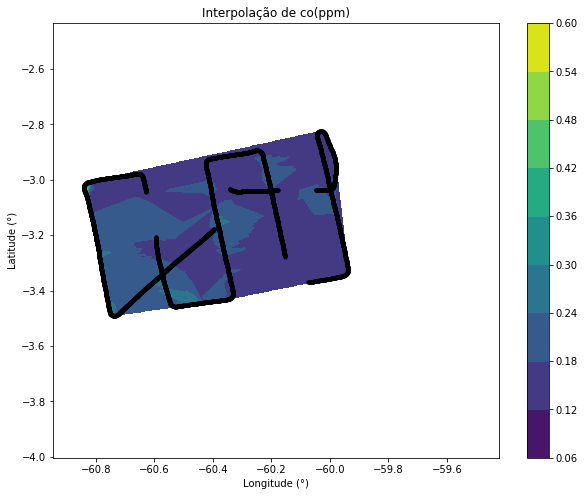

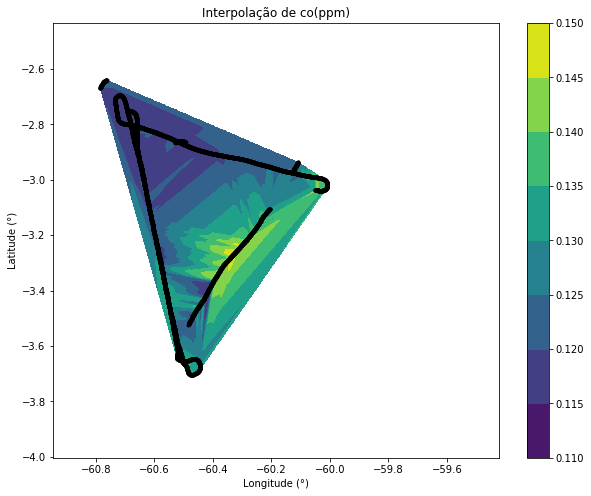

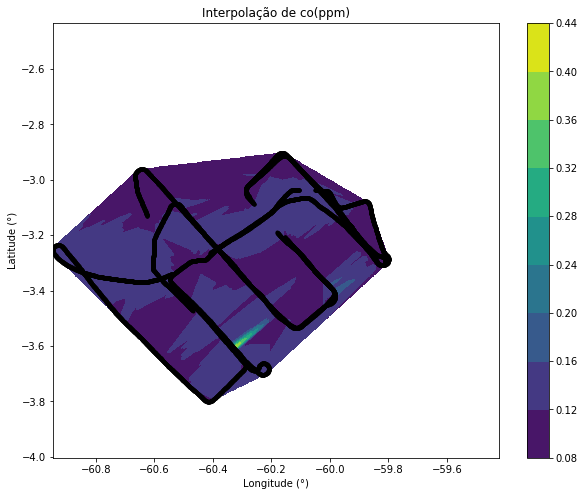

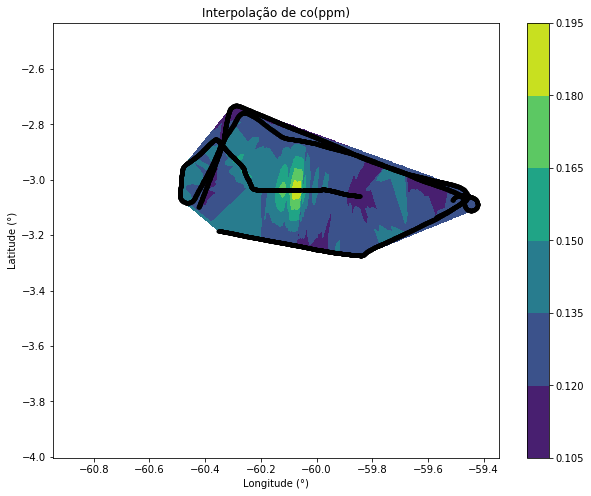

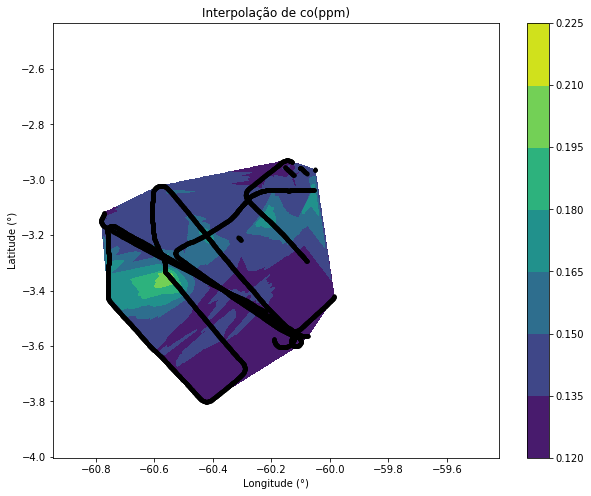

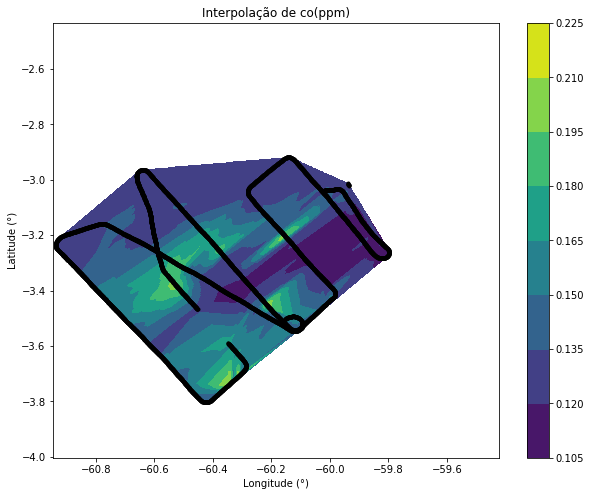

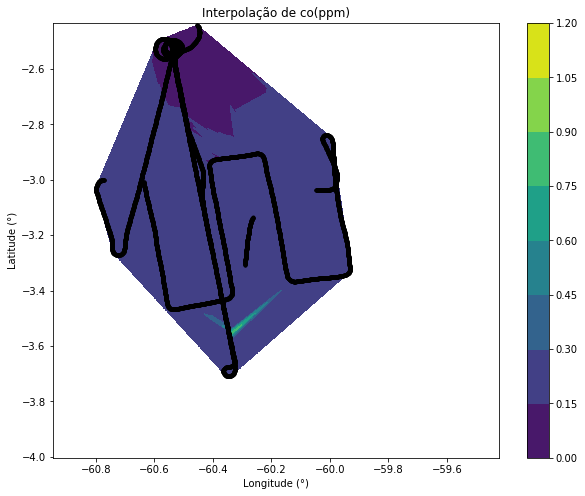

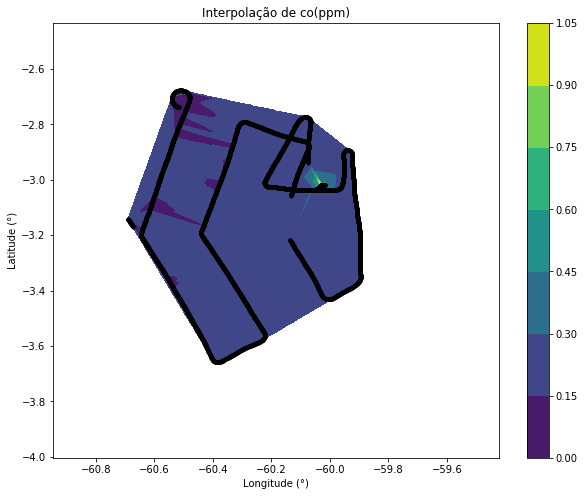

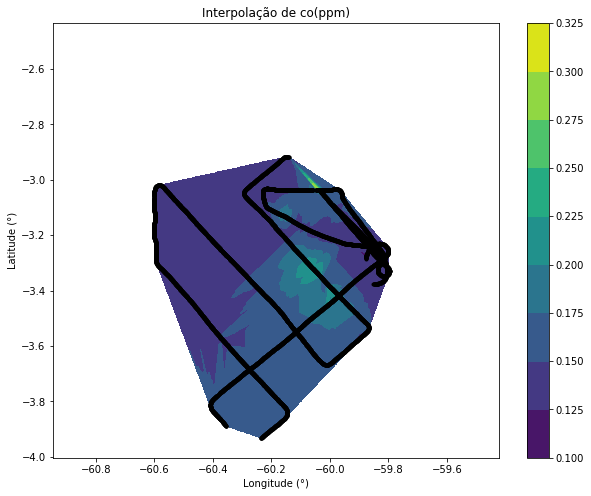

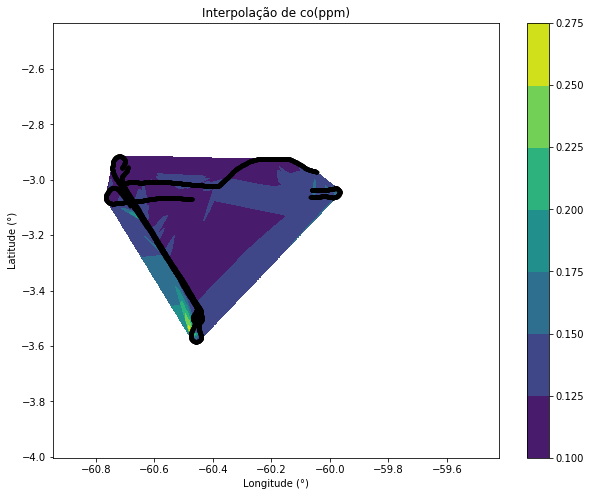

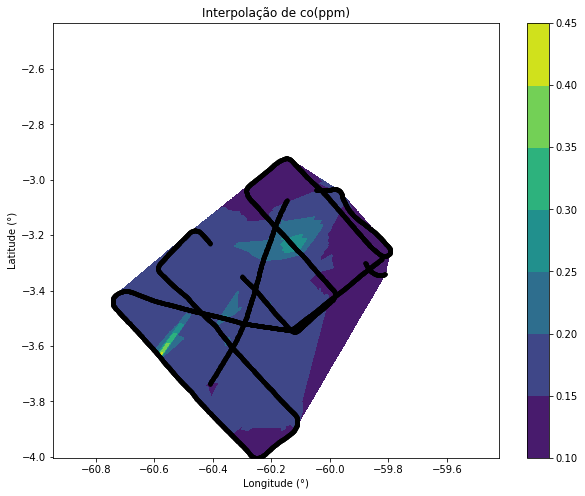

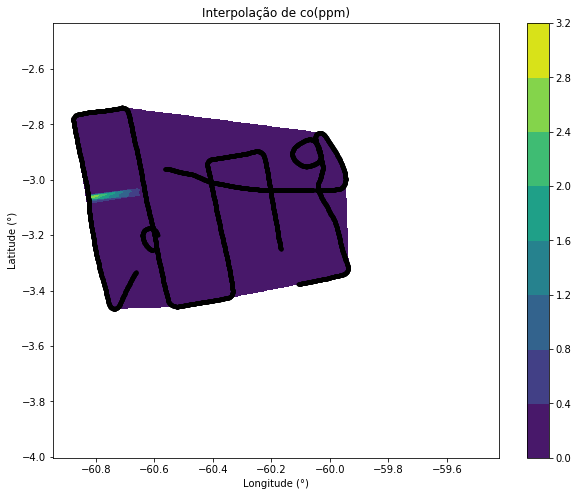

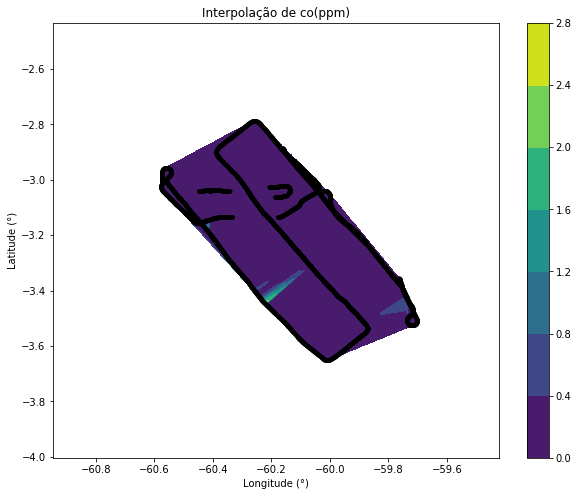

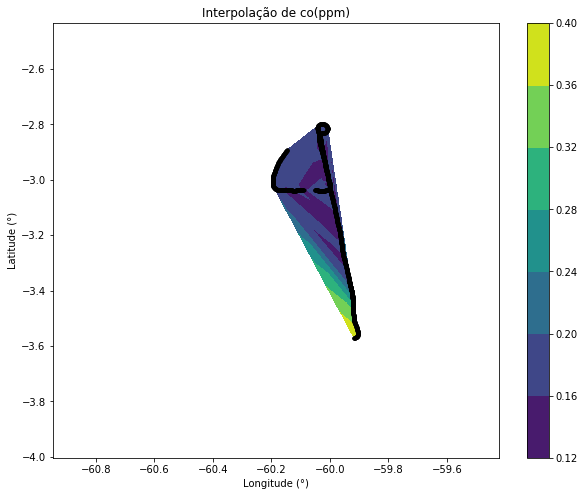

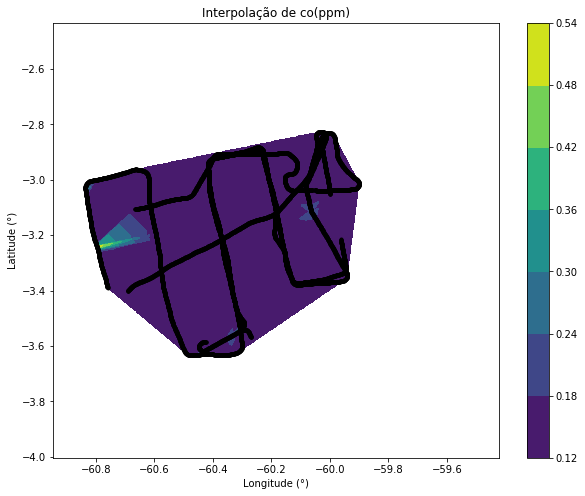

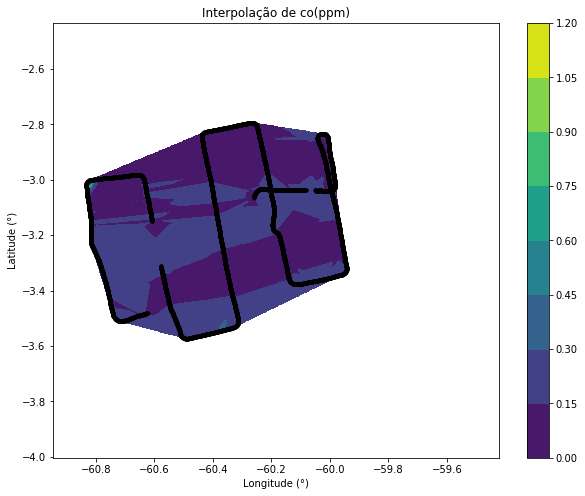

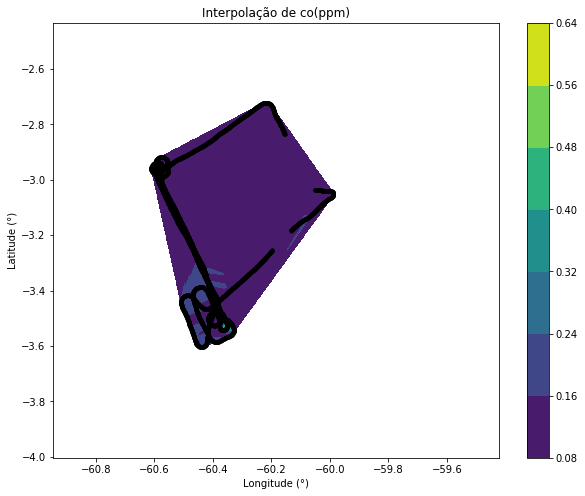

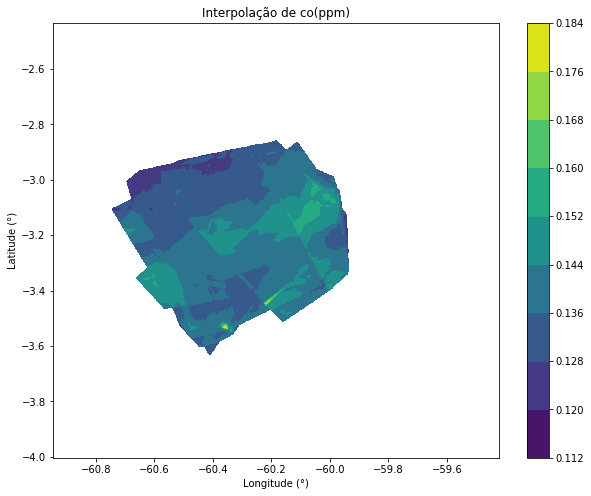

In [15]:
interpolacao_estacao('co(ppm)', 'seca')

,-61.215,-61.213800000000006,-61.21260000000001,-61.21140000000001,-61.210200000000015,-61.20900000000002,-61.20780000000002,-61.20660000000002,-61.205400000000026,-61.20420000000003,...,-59.38980000000426,-59.38860000000426,-59.38740000000426,-59.386200000004266,-59.38500000000427,-59.38380000000427,-59.382600000004274,-59.38140000000428,-59.38020000000428,-59.37900000000428
-3.8712,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8692,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8672,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8652,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8632,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8612,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8592,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8572,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8552,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
-3.8532,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


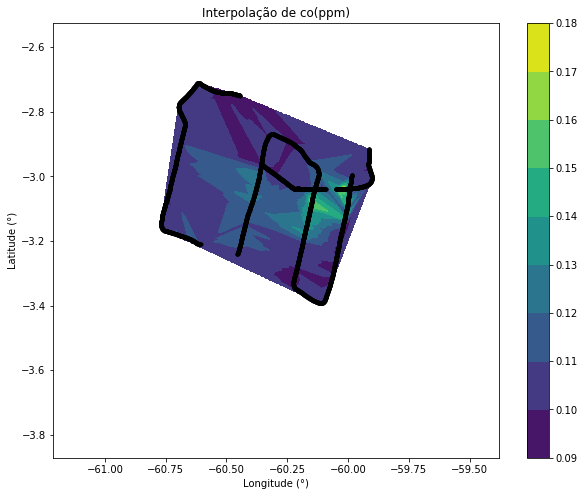

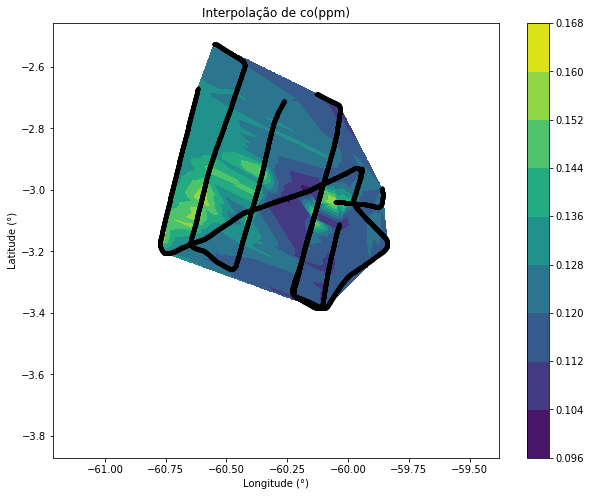

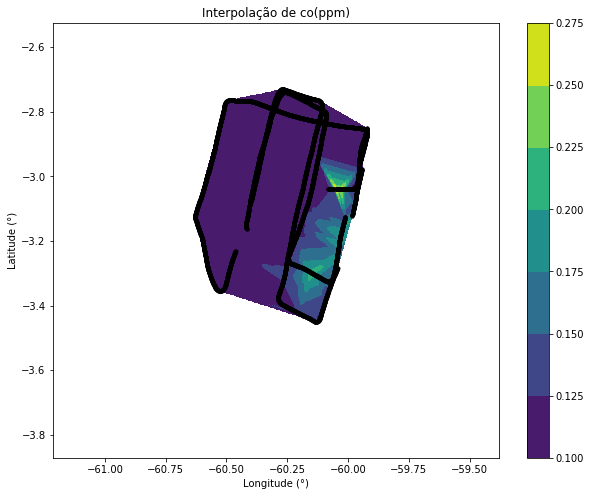

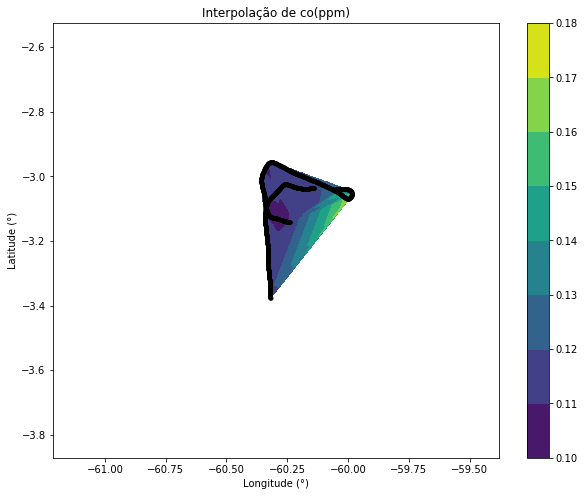

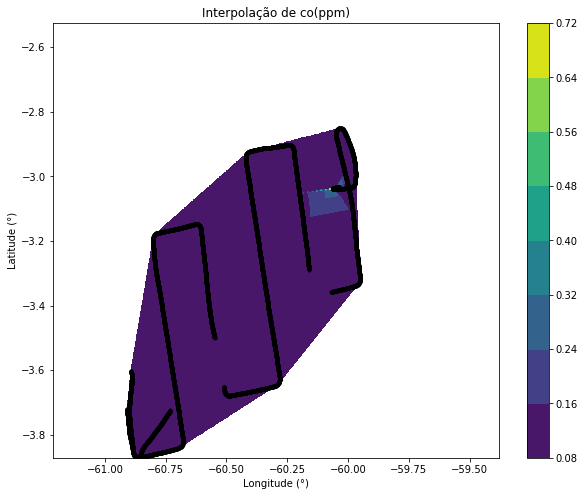

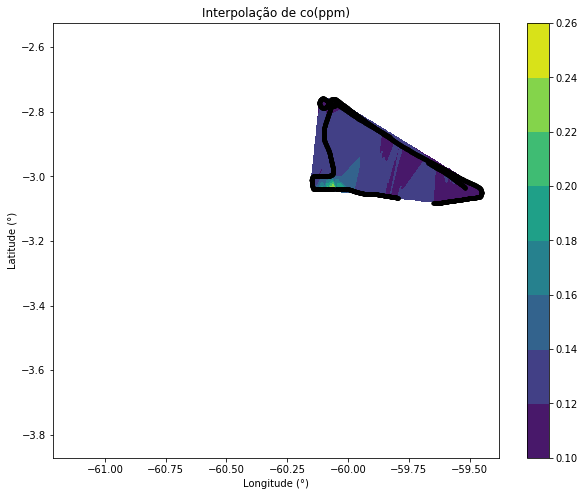

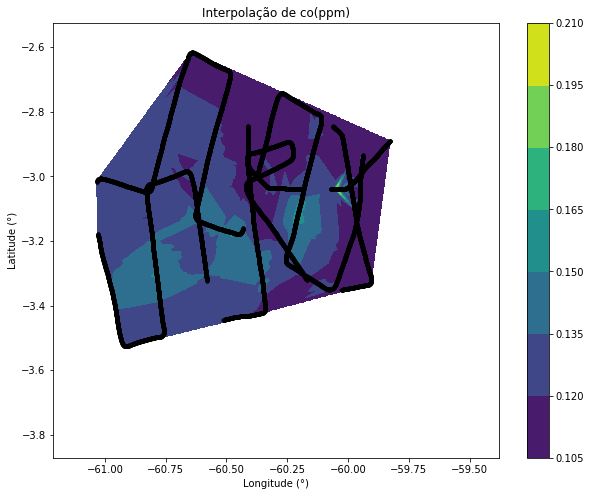

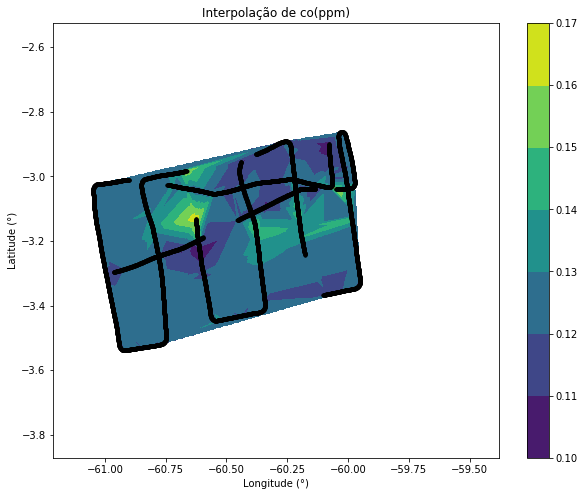

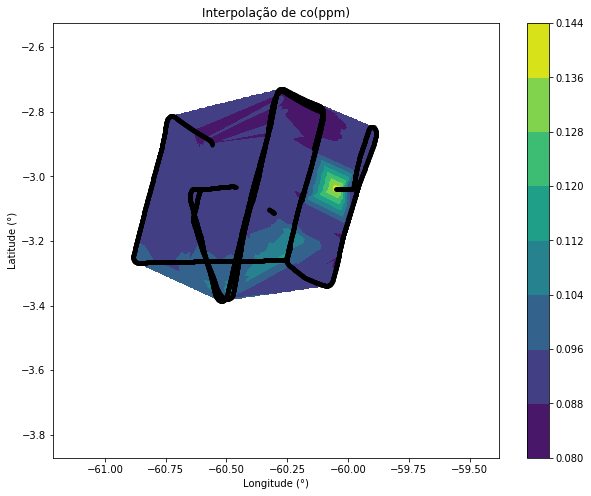

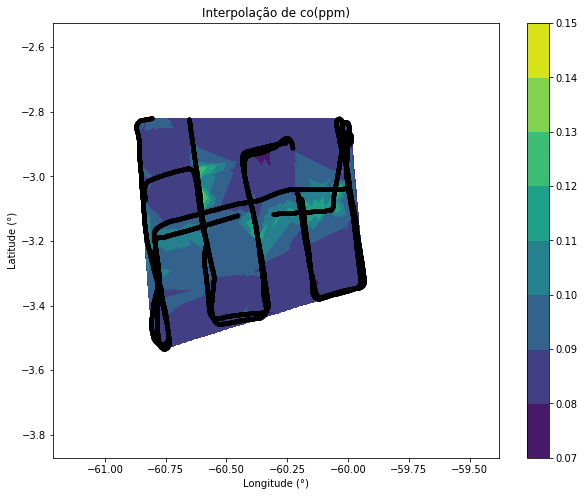

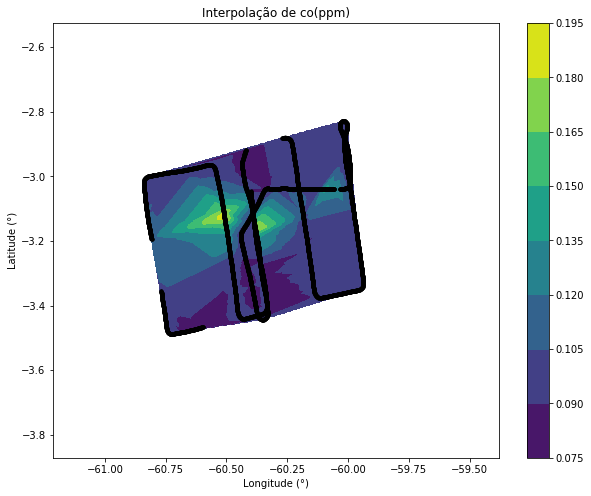

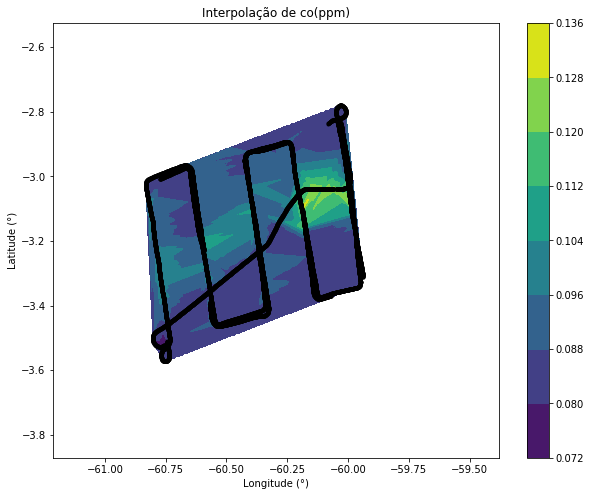

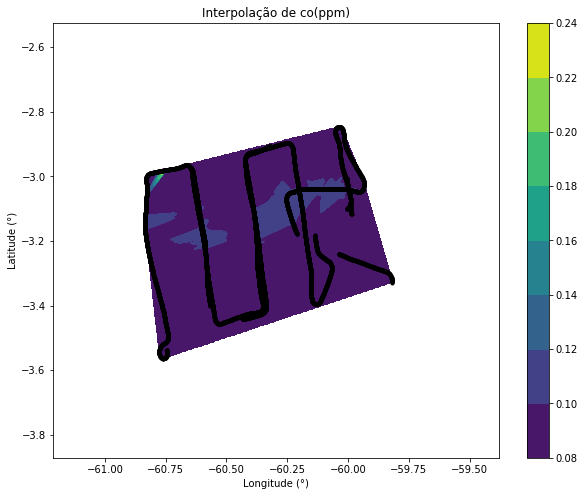

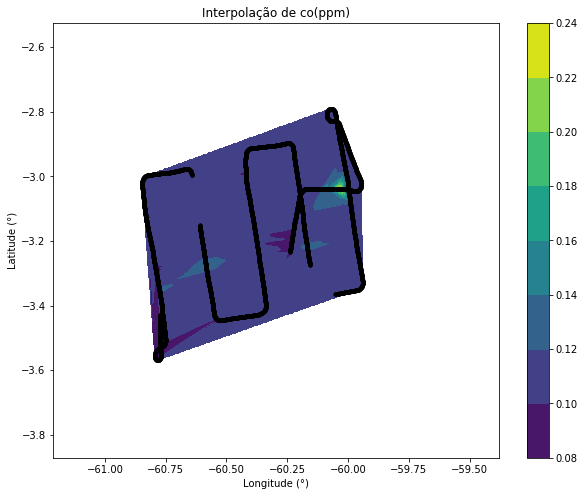

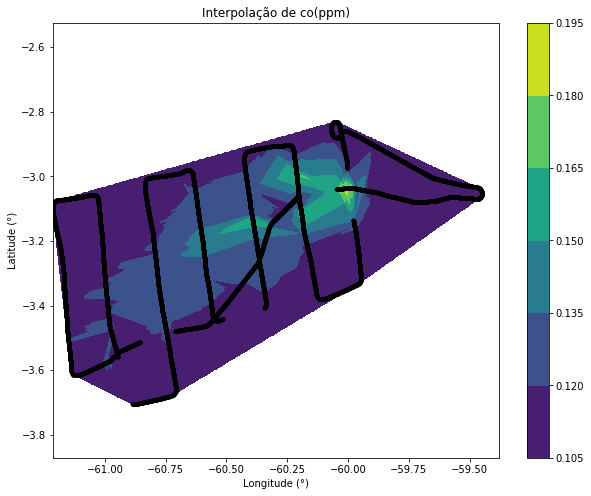

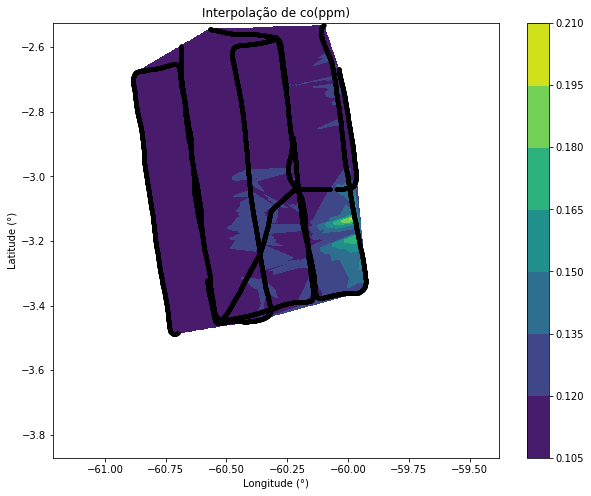

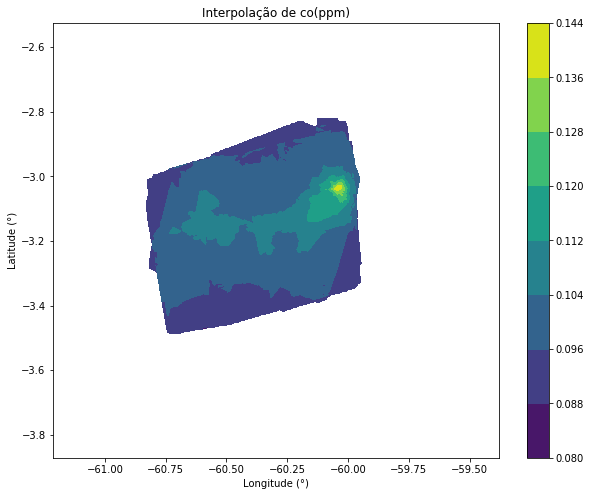

In [16]:
interpolacao_estacao('co(ppm)', 'chuvosa')